Alex - Reasearch - 11. 3. 21

## de Prado: Sequential Bootstrapping

The purpose of this notebook is to illustrate de Prado's concept of sequential bootstrapping and compare it later to Chan's approach.
The problem in financial applications is that observations are not iid. Unfortunately, most ML algos rely on the iid assumption.


#### Context 

We know that de Prado uses the triple barrier method to label the samples. Each label in a triple barrier event has a label index (can be interpreted as when the trade was opened) and a label end time (when the first barrier was touched - can be interpreted as when the label was closed). 

Let's look at an example of 3 samples and assume that: 

- sample A was generated at $t_1$ and first barrier was touched at $t_8$
- sample B was generated at $t_3$ and first barrier was touched at $t_6$
- sample C was generated at $t_7$ and first barrier was touched at $t_9$


So A's label is a function of price returns on $[t_1, t_8]$, which overlaps with with $[t_3, t_6]$ used by B. Hence A uses information from B. A also has an on overlap with C. 

De Prado says that labels $y_i$ and $y_j$ are concurrent at $t$ if they are a function of at least on common
return at $r_{t-1,t}$.

So in terms of concurrency: A is the "dirtiest" as it uses information from B and C. While C is the "purest" as it doesn't any information from B or A. By using the average label uniqueness we can measure how "pure" our data set is based on concurrency of the labels.  **It is desirable to use a data set that has the least amount of overlap (i.e. is very "pure") to train an algorithm so that we get as close to the iid assumption as possible**. 

#### Sampling with replacement

Bagging algos such as RF bootstrap oberservations. However, if many observations overlap with one another (i.e. we have low average label uniqueness) then bootstrapping will likely create samples which have redundancy. This makes RF's inefficient because in-bag observations will be very similar to out-of-bag ones, which will inflate the out-of-bag accuracy. The solution to the concurrency problem is Sequential Bootstrapping.


#### Sequential bootstraping

In the first draw, an observation is drawn from the uniform distribution. For the second draw, the sequential bootstrap (SB) reduces the probability of the observation that was drawn earlier from being drawn again. This process continues until the required number of draws are made. To implement this scheme, we first need to determine all the bars that a label (of an observation) uses. We compute a binary matrix that has bars on one axis and the labels on the other (this is called indicator matrix). This matrix is then used to compute the the average uniqueness of each observation.

The sequential bootstrap process iteratively selects observations while adjusting the draw probabilities of each observation at each step of the loop.

#### SBRandom Forest

As explained, sequential bootstrapping can be used to make the data set more "pure". The next step would be to combine a random forest with sequential bootstrapping to increase the quality of the model. 

#### Illustration

In [52]:
# import all the necessary stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
#from mlfinlab.util import utils

from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping
from mlfinlab.util import multiprocess




In [53]:
%matplotlib inline

In [54]:
# Read in data
# data = pd.read_csv('official_data/dollar_bars.csv', nrows=40000)
data = pd.read_csv('C:/Users/axarz/Desktop/Thesis/sample_dollar_bars.csv')

data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)
close_prices = data['close']

print(close_prices.head())
print("-----------------")
print('\nNo of NANs: {:}'.format(close_prices.isna().sum()))

date_time
2011-07-31 23:31:58.810    1305.75
2011-08-01 02:55:17.443    1306.50
2011-08-01 07:25:56.319    1305.00
2011-08-01 08:33:10.903    1300.00
2011-08-01 10:51:41.842    1307.75
Name: close, dtype: float64
-----------------

No of NANs: 0


In [55]:
# Compute daily volatility
vol = mlfinlab.util.volatility.get_daily_vol(close=close_prices, lookback=50)

vol.head()

date_time
2011-08-01 23:41:59.859         NaN
2011-08-02 06:46:46.576    0.003240
2011-08-02 07:31:03.237    0.003251
2011-08-02 09:07:37.276    0.002876
2011-08-02 10:52:48.191    0.003222
Name: close, dtype: float64

In [56]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = filters.cusum_filter(close_prices, threshold=vol.mean())


# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(cusum_events, close_prices, num_days=1)
vertical_barriers.head()

triple_barrier_events = labeling.get_events(close=close_prices,
                                               t_events=cusum_events,
                                               pt_sl=[1, 1],
                                               target=vol,
                                               min_ret=0.01,
                                               num_threads=1,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=None)


triple_barrier_events.head()

,t1,trgt,pt,sl
2011-08-04 01:57:00.466,2011-08-04 10:27:24.326,0.011841,1,1
2011-08-04 09:53:01.844,2011-08-04 13:50:40.606,0.011918,1,1
2011-08-04 19:30:23.101,2011-08-04 20:01:48.966,0.010392,1,1
2011-08-04 19:59:41.879,2011-08-05 12:30:19.803,0.013613,1,1
2011-08-05 12:30:19.803,2011-08-05 13:51:55.449,0.013697,1,1


Now get ave. uniquness of the whole data set. 

In [80]:
av_unique = get_av_uniqueness_from_triple_barrier(triple_barrier_events, close_prices, num_threads=3)
av_unique.mean()

2021-03-11 15:12:01.710474 100.0% num_concurrent_events done after 0.09 minutes. Remaining 0.0 minutes..
2021-03-11 15:12:09.304686 100.0% _get_average_uniqueness done after 0.08 minutes. Remaining 0.0 minutes..


tW    0.278286
dtype: float64

**We would like to build our a RF such that the av_unique is as high as possible So that means during the bootstrap we want to choose labels that are non-concurrent.** And we do that with the sequential bootstrap. 

Let's assume that:

- $y_0$ is a function of return $r_{0,2}$
- $y_1$ is a function of return $r_{2,3}$
- $y_2$ is a function of return $r_{4,5}$

The first thing we need to do is build an indicator matrix. Cols of that matrix are the samples and rows are the price returns

In [83]:
ind_mat = pd.DataFrame(index=range(0,6), columns=range(0,3))
ind_mat.loc[:,0] = [1,1,1,0,0,0]
ind_mat.loc[:,1] = [0,0,1,1,0,0]
ind_mat.loc[:,2] = [0,0,0,0,1,1]
ind_mat

,0,1,2
0,1,0,0
1,1,0,0
2,1,1,0
3,0,1,0
4,0,0,1
5,0,0,1


(can use get_ind_mat from mlfinlab to build indicator matrix from triple barrier events)

In [96]:
triple_barrier_events.dropna(axis=0, how='any', inplace=True)
triple_barrier_ind_mat = get_ind_matrix(triple_barrier_events, close_prices)
triple_barrier_ind_mat.shape
triple_barrier_ind_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [97]:
# get ave label uniqueness with a function

ind_mat_uniqueness = get_ind_mat_average_uniqueness(triple_barrier_ind_mat)
ind_mat_uniqueness

0.24778671523245813

As you can see it's quite close to the values generated by get_av_uniqueness_from_triple_barrier function call

Let's go back to seq bs: 

In sequential bootstrapping we start with an empty array (phi) and loop through all samples to get the prob of choosing
the sample based on ave uniqueness of reduced indicator matrix constructed from previously chosen columns+sample

In [121]:
ind_mat 
#Assume we have chosen 1 to be the sample in the first step
phi = [1] # Sample chosen from the 1st step
uniqueness_array = np.array([None, None, None])
for i in range(0, 3):
    ind_mat_reduced = ind_mat[:, phi + [i]] #give me the already chosen sample and the next one
    label_uniqueness = bootstrapping.get_ind_mat_label_uniqueness(ind_mat_reduced)[-1]
    print(label_uniqueness)
    uniqueness_array[i] = (label_uniqueness[label_uniqueness > 0].mean())

prob_array = uniqueness_array / sum(uniqueness_array)



[1.  1.  0.5 0.  0.  0. ]
[0.  0.  0.5 0.5 0.  0. ]
[0. 0. 0. 0. 1. 1.]


In [118]:
uniqueness_array
prob_array

array([0.35714285714285715, 0.21428571428571427, 0.42857142857142855],
      dtype=object)

So probably the second chosen feature willl be 2 cuz it has the largest probability (0.428). As you can see now, the algo has chosen the two least concurrent labels (1 and 2) so far. 

If we run this algo further, we would see that sequential bootstrapping tries to minimize the probability of repeated samples. We can use the seq_bootstrap() to do it:

In [124]:
samples = seq_bootstrap(ind_mat, sample_length=4, warmup_samples=[1], verbose=True)

[0.33333333 0.33333333 0.33333333]
[0.35714286 0.21428571 0.42857143]
[0.45454545 0.27272727 0.27272727]
[0.5 0.3 0.2]


In [125]:
samples

[1, 2, 2, 0]

Let's see how seq. b.s. increases the average label uniqueness:

In [127]:
standard_unq_array = np.zeros(10000) * np.nan # Array of random sampling uniqueness
seq_unq_array = np.zeros(10000) * np.nan # Array of Sequential Bootstapping uniqueness
for i in range(0, 10000):
    bootstrapped_samples = seq_bootstrap(ind_mat, sample_length=3)
    random_samples = np.random.choice(ind_mat.shape[1], size=3)
    
    random_unq = get_ind_mat_average_uniqueness(ind_mat[:, random_samples])
    random_unq_mean = random_unq[random_unq > 0].mean()

    sequential_unq = get_ind_mat_average_uniqueness(ind_mat[:, bootstrapped_samples])
    sequential_unq_mean = sequential_unq[sequential_unq > 0].mean()
    
    standard_unq_array[i] = random_unq_mean
    seq_unq_array[i] = sequential_unq_mean

In [129]:
np.median(standard_unq_array), np.median(seq_unq_array)


(0.6666666666666666, 0.6666666666666666)

In [130]:
np.mean(standard_unq_array), np.mean(seq_unq_array)

(0.6438035714285714, 0.7049958333333333)

KDE plots confirm that seq. b.s. gives higher ave. label uniqueness

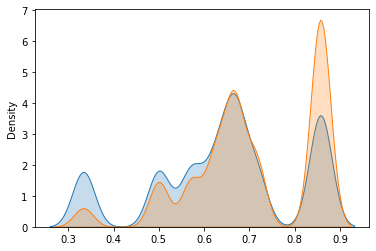

In [134]:
sns.kdeplot(standard_unq_array, shade=True, label='Random Sampling')
sns.kdeplot(seq_unq_array, shade=True, label='Sequential Sampling')

#### Take away
- we know now how concurrency can make a data set impure
- we know that seq. b.s. can help us tackling the concurrency problem: **It helps us to bootstrap samples that are closer to iid!**
- next step is to combine the standard RF with seq. b.s. in order to improve the RF's performance